### Установка библиотеки и подключение к диску.


In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
!pip install tensorflow

In [3]:
!python -m pip install -U giotto-tda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.7 MB/s eta 0:00:00


In [4]:
!pip install gudhi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.7 MB/s eta 0:00:00


In [5]:
!pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 6.5 MB/s eta 0:00:00


In [6]:
# !pip install -U kaleido

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = '/content/drive/MyDrive/hse/kursach1/'

### Загружаем данные.

Функция от названия файла, возвращает массив (245, 600) - данные RS_0 и RS_FE

In [9]:
from numpy import load


def file_to_array(filename):
    '''
    Open file and download data.
    :param filename: str, path to the file
    :return: two arrays: rs_0 and rs_fe
    '''
    archive = load(filename)
    files = archive.files
    array = archive['data']
    shape = archive['shape']
    indptr = archive['indptr']

    data = np.empty((1, shape[1]))

    for i in range(shape[0]):
        data = np.append(data, [array[indptr[i]:indptr[i + 1]]], axis=0)

    return data[1:][:, :300], data[1:][:, 300:]


rs_0, rs_fe = file_to_array(path + 'human fmri/human fmri exp rs_0 vs. fe merged p1.npz')

In [10]:
rs_0.shape

(245, 300)

### Получение матрицы ковариаций и персистентной диаграммы.

Считаем матрицу ковариаций и получаем граф.

In [11]:
import pandas as pd
import numpy as np


def corr_matrix(data, threshold):
    '''
    Computing covariance matrix of data cloud, inf if cov < threshold
    :param data:  (N, M) numpy array
    :param threshold: parameter to cut
    :return: covariance matrix shape (N, N)
    '''
    f = lambda x: abs(x) if abs(x) >= threshold else 0
    vfunc = np.vectorize(f)

    corr_array = np.corrcoef(data)

    corr_array = vfunc(corr_array)
    np.fill_diagonal(corr_array, 0)

    return [1 - corr_array]


corr_array = corr_matrix(rs_fe, 0.5)
corr_array[0].shape

(245, 245)

Посмотрим как выглядит полученная матрица расстояний.

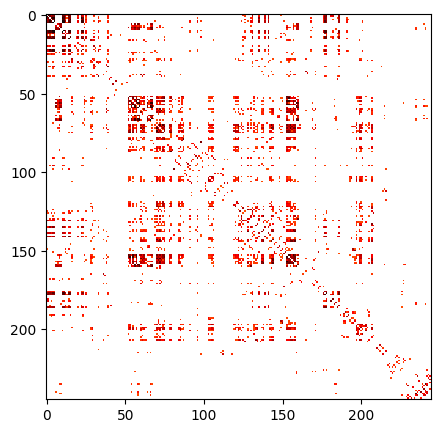

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))

plt.imshow(corr_array[0], cmap='hot', interpolation='nearest')

plt.show()

Персистентная диаграмма по графу для пациента p1.


In [13]:
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram


def pers_diagram(data, n_homologies):
    '''
    Computing persistent diagram, given distance matrix NxN and number of homologies to compute.
    :param data: (N, N) distance matrix
    :param n_homologies: number until to compute homologies
    :return: persistent diagram shape (1, k, 2)
    '''
    homology_dimensions = [_ for _ in range(n_homologies)]

    persistence = VietorisRipsPersistence(
        homology_dimensions=homology_dimensions,
        n_jobs=6,
        metric="precomputed"
    )

    diagram = persistence.fit_transform(data)

    return diagram


plot_diagram(pers_diagram(corr_array, 3)[0])

### Делаем диаграммы устойчивости для каждого пациента rs_0 и rs_fe  и загружаем на диск.

In [14]:
def get_diagrams_array(threshold, n_hom):
    '''
    Computes distance matricies, persistent diagrams, stack in one array
    :param threshold: threshold
    :param n_hom: number until to compute homologies
    :return: (46, 1, k_i, 2) - 46 persistence diagrams for 23 patients
    '''
    X = []
    for i in range(1, 24):
        filename = path + f'human fmri/human fmri exp rs_0 vs. fe merged p{i}.npz'

        rs_0, rs_fe = file_to_array(filename)

        corr_rs_0 = corr_matrix(rs_0, threshold)
        corr_rs_fe = corr_matrix(rs_fe, threshold)

        rs_0_persistent = pers_diagram(corr_rs_0, n_hom)[:, :, :2]
        rs_fe_persistent = pers_diagram(corr_rs_fe, n_hom)[:, :, :2]

        X.append(rs_0_persistent)
        X.append(rs_fe_persistent)

    for i in range(0, 46):
        X[i] = np.delete(X[i], np.where(X[i] == [0., 0.]), axis=1)
    return X


Сохраняем диаграммы для разных параметров в виде .npz на диск.

In [15]:
# import os

# parameters = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
# number_of_homologies = [2, 3]

# for t in parameters:
#     for n in number_of_homologies:
#         for i in range(1, 24):
#             filename = path + f'human fmri/human fmri exp rs_0 vs. fe merged p{i}.npz'

#             rs_0, rs_fe = file_to_array(filename)

#             corr_rs_0 = corr_matrix(rs_0, t)
#             corr_rs_fe = corr_matrix(rs_fe, t)

#             rs_0_persistent = pers_diagram(corr_rs_0, n)[:, :, :2]
#             rs_fe_persistent = pers_diagram(corr_rs_fe, n)[:, :, :2]

#             rs_0_persistent = np.delete(rs_0_persistent, np.where(rs_0_persistent == [0., 0.]), axis=1)
#             rs_fe_persistent = np.delete(rs_fe_persistent, np.where(rs_fe_persistent == [0., 0.]), axis=1)

#             np.savez(path + f'results/diagram {n}; {t}/rs_0 p{i}.npz', rs_0_persistent)
#             np.savez(path + f'results/diagram {n}; {t}/rs_fe p{i}.npz', rs_fe_persistent)

### Загружаем диаграммы устойчивости с диска.


In [16]:
def load_data(filename):
    archive = load(filename)
    files = archive.files
    array = archive['arr_0']
    return array


def load_diagrams(t, n):
    '''
    Load persistence diagrams from the Drive
    :param t: threshold
    :param n: number until to compute homologies
    :return: (46, 1, k_i, 2) - 46 persistence diagrams for 23 patients
    '''
    X = []
    for i in range(1, 24):
        filename1 = f'/content/drive/MyDrive/hse/kursach1/results/diagram {n}; {t}/rs_0 p{i}.npz'
        filename2 = f'/content/drive/MyDrive/hse/kursach1/results/diagram {n}; {t}/rs_fe p{i}.npz'

        rs_0_persistent = load_data(filename1)
        rs_fe_persistent = load_data(filename2)

        X.append(rs_0_persistent)
        X.append(rs_fe_persistent)

    return X


### K-means с метрикой расстояние Вассерштейна.


Реализация класса KMeans, где новый центроид выбирается функцией lagrangian_barycenter, считается расстояние при помощи функции wasserstein_distance.



In [ ]:
from gudhi.wasserstein import wasserstein_distance
from gudhi.wasserstein.barycenter import lagrangian_barycenter

In [ ]:
class KMeans:
    def __init__(self, n_clusters=2, max_iters=10):
        self.n_clusters = n_clusters
        self.max_iters = max_iters

    def wasserstein(self, diagram):
        '''
        Compute Wasserstein distance from first and second centroid to diagram
        :param diagram: (1, k, 2) numpy array - persistence diagram
        :return: [d1, d2] distances from each centroid
        '''
        return [wasserstein_distance(diagram[0], self.centroids[0][0]),
                wasserstein_distance(diagram[0], self.centroids[1][0])]

    def match_centroids(self, new_centroids):
        '''
        Check if new centroids match with old
        :param new_centroids: new centroids ;)
        :return: bool, true if new centroids are the same
        '''
        return (new_centroids[0].shape == self.centroids[0].shape or new_centroids[0].shape == self.centroids[1].shape) \
            and (new_centroids[1].shape == self.centroids[1].shape or new_centroids[1].shape == self.centroids[0].shape) \
            and np.all([new_centroids[0], self.centroids[0]]) and np.all([new_centroids[1], self.centroids[1]])

    def fit(self, X):
        answers = np.zeros(len(X))
        answers[::2] = 1

        # Initialize centroids randomly
        c1, c2 = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = [X[c1], X[c2]]

        for _ in range(self.max_iters):
            # Assign each data point to the nearest centroid
            labels = self.assign_labels(X)

            # Update centroids
            new_centroids = self.update_centroids(X, labels)

            matches = max(np.sum(answers == labels), np.sum(1 - answers == labels))

            if self.match_centroids(new_centroids):
                return

            self.centroids = new_centroids

    def assign_labels(self, X):
        # Compute wasserstein distances from each data point to centroids
        distances = np.array(list(map(self.wasserstein, X)))
        # Assign labels based on the nearest centroid
        return np.argmin(distances, axis=1)

    def update_centroids(self, X, labels):
        # Regroup diagrams
        groups = [[] for _ in range(self.n_clusters)]
        for i in range(len(labels)):
            groups[labels[i]].append(X[i][0])

        # Compute new barycenters
        new_centroids = []
        for i in range(self.n_clusters):
            centroid = lagrangian_barycenter(pdiagset=groups[i])[np.newaxis, :, :]
            new_centroids.append(centroid)

        return new_centroids


def cluster(X):
    '''
    Cluster data
    :param X: (N, 1, k_i, 2) array
    :return: (N,) array of assigned labels
    '''
    kmeans = KMeans()
    kmeans.fit(X)
    labels = kmeans.assign_labels(X)

    return labels

### Метрики

Функции для расчёта [метрик](https://habr.com/ru/companies/yandex/articles/500742/) качества кластеризации.

In [17]:
def rates(labels):
    '''
    Count accuracy, tp, fp, tn, fn
    :param labels: labels
    :return: accuracy, tp, fp, tn, fn
    '''
    n = len(labels)
    answers = np.zeros(n)
    answers[::2] = 1
    if np.sum(answers == labels) < np.sum(1 - answers == labels):
        answers = 1 - answers

    matches = max(np.sum(answers == labels), np.sum(1 - answers == labels))
    acc = matches / len(labels)
    tp, fp, tn, fn = 0, 0, 0, 0
    for i in range(n):
        for j in range(n):
            class_ = (answers[i] == answers[j])
            cluster = (labels[i] == labels[j])
            if class_ and cluster:
                tp += 1
            elif not class_ and cluster:
                fp += 1
            elif class_ and not cluster:
                fn += 1
            else:
                tn += 1
    return acc, tp, fp, tn, fn


def kluster_metrics(labels):
    '''
    Count accuracy, precision, recall, f-score
    :param labels: labels
    :return:  accuracy, precision, recall, f1
    '''
    acc, tp, fp, tn, fn = rates(labels)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return acc, precision, recall, f1

Метрики оценки качества кластеризации.

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc


def class_metrics(predictions, true_labels):
    '''
    Count accuracy, precision, recall, f-score, AUC-ROC
    :param predictions: probability values for classes
    :param true_labels: answers
    :return: accuracy, precision, recall, f1, auc_roc
    '''
    labels = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(true_labels, labels)
    precision = precision_score(true_labels, labels)
    recall = recall_score(true_labels, labels)
    f1 = f1_score(true_labels, labels)

    fpr, tpr, thresholds = roc_curve(true_labels, predictions[:, 1])
    auc_roc = auc(fpr, tpr)

    return accuracy, precision, recall, f1, auc_roc

### KNN

In [19]:
from gudhi.wasserstein import wasserstein_distance
from gudhi.wasserstein.barycenter import lagrangian_barycenter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [20]:
def get_distance_matrix(X):
    n = len(X)

    distance_matrix = np.zeros((n, n))

    for i in range(46):
        for j in range(46):
            if i < j:
                distance_matrix[i][j] = wasserstein_distance(X[i][0], X[j][0])
            else:
                distance_matrix[i][j] = distance_matrix[j][i]

    return distance_matrix

In [35]:
parameters = [0.5, 0.55, 0.6, 0.65, 0.7]
number_of_homologies = [2, 3]
# Инициализируем табличку
df = pd.DataFrame(
    {'n_homologies': [], 'threshold': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc-roc': []})
# Инициализируем ответы
true_labels = np.zeros(46)
true_labels[::2] = 1

# y = to_categorical(true_labels)

for n_hom in number_of_homologies:
    for param in parameters:
        print(' ')
        print('-' * 50)
        print(' ')
        print(f'Iteration with n = {n_hom}, t = {param} is starting...')
        # Получаем диаграммы устойчивости
        diagrams = load_diagrams(param, n_hom)

        X_dist = get_distance_matrix(diagrams)

        X_dist_train = X_dist[:36, :36]
        X_dist_test = X_dist[36:, :36]
        y_train = true_labels[:36]
        y_test = true_labels[36:]

        # Создадим классификатор kNN с предвычисленной метрикой
        knn = KNeighborsClassifier(n_neighbors=2, metric='precomputed')

        # Обучим модель на обучающей выборке
        knn.fit(X_dist_train, y_train)

        # Сделаем предсказания для тестовой выборки
        train_predictions = knn.predict_proba(X_dist_train)

        # Получаем предсказания для тестовой выборки
        test_predictions = knn.predict_proba(X_dist_test)
        # y_pred = np.argmax(predictions, axis=1)

        # Вычисление метрик
        # np.concatenate((train_predictions, test_predictions), axis=0)
        accuracy, precision, recall, f1, auc_roc = class_metrics(test_predictions, y_test)

        new_row = pd.DataFrame([[n_hom, param, accuracy, precision, recall, f1, auc_roc]],
                               columns=['n_homologies', 'threshold', 'accuracy', 'precision', 'recall', 'f1',
                                        'auc-roc'])

        print(new_row)
        # Сохраняем результаты
        df = pd.concat([df, new_row])
        df.to_csv(path + '/results/knn/result_table_test.csv', index=False)
        print(f'homology {n_hom} with parameter {param} done')

 
--------------------------------------------------
 
Iteration with n = 2, t = 0.5 is starting...


KeyboardInterrupt: 

In [72]:
a = np.array([[1, 2], [3, 4], [0, 0]])
b = np.array([[5, 6]])
print(np.concatenate((a, b), axis=0).shape)
# b.shape

(4, 2)


In [ ]:
df

,n_homologies,threshold,accuracy,precision,recall,f1,auc-roc
0,2.0,0.50,0.5,0.500000,0.2,0.285714,0.50
0,2.0,0.55,0.5,0.500000,0.2,0.285714,0.66
0,2.0,0.60,0.4,0.333333,0.2,0.250000,0.42
0,2.0,0.65,0.5,0.500000,0.2,0.285714,0.34
0,2.0,0.70,0.6,0.600000,0.6,0.600000,0.66
0,3.0,0.50,0.5,0.500000,0.6,0.545455,0.50
0,3.0,0.55,0.5,0.500000,0.2,0.285714,0.42
0,3.0,0.60,0.5,0.500000,0.4,0.444444,0.44
0,3.0,0.65,0.4,0.400000,0.4,0.400000,0.36
0,3.0,0.70,0.6,0.600000,0.6,0.600000,0.62


### Метод 1. Кластеризация диаграмм устойчивости алгоритмом KMeans.

Итерируемся по разным значениям threshold и числом голмологий, результат в таблице на диске.

In [ ]:
import pandas as pd

parameters = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
number_of_homologies = [2, 3]

# Инициализируем табличку
df = pd.DataFrame(
    {'n_homologies': [], 'threshold': [], 'labels': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []})

for n_hom in number_of_homologies:
    for param in parameters:
        # Получаем диаграммы устойчивости
        X = load_diagrams(param, n_hom)
        # Кластеризуем данные
        labels = cluster(X)
        labels_str = ' '.join([str(int(label)) for label in labels])
        # Считаем метрики
        acc, prec, rec, f1 = kluster_metrics(labels)
        # Сохраняем результаты
        new_row = pd.DataFrame([[n_hom, param, labels_str, acc, prec, rec, f1]],
                               columns=['n_homologies', 'threshold', 'labels', 'accuracy', 'precision', 'recall', 'f1'])
        df = pd.concat([df, new_row])
        df.to_csv(path + 'results/result_table.csv', index=False)
        print(f'homology {n_hom} with parameter {param} done')

homology 2 with parameter 0.5 done
homology 2 with parameter 0.55 done
homology 2 with parameter 0.6 done
homology 2 with parameter 0.65 done
homology 2 with parameter 0.7 done
homology 2 with parameter 0.75 done
homology 3 with parameter 0.5 done
homology 3 with parameter 0.55 done
homology 3 with parameter 0.6 done
homology 3 with parameter 0.65 done
homology 3 with parameter 0.7 done
homology 3 with parameter 0.75 done


In [ ]:
df

,n_homologies,threshold,labels,accuracy,precision,recall,f1
0,2.0,0.50,1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 ...,0.521739,0.500743,0.637051,0.560732
0,2.0,0.55,1 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 ...,0.565217,0.508257,0.523629,0.515829
0,2.0,0.60,0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 ...,0.565217,0.508443,0.512287,0.510358
0,2.0,0.65,1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 ...,0.543478,0.503460,0.550095,0.525745
0,2.0,0.70,1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 ...,0.652174,0.545966,0.550095,0.548023
0,2.0,0.75,0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 ...,0.630435,0.532491,0.557656,0.544783
0,3.0,0.50,1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 ...,0.565217,0.507589,0.568998,0.536542
0,3.0,0.55,0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 ...,0.521739,0.500945,0.500945,0.500945
0,3.0,0.60,1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 ...,0.521739,0.500945,0.500945,0.500945
0,3.0,0.65,1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 ...,0.630435,0.533962,0.534972,0.534466


### Метод 2. 1D CNN.


In [19]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras import utils
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold

utils.set_random_seed(0)
tf.random.set_seed(0)

Функция для перевода диаграммы устойчивости в одномерный массив, сортировка кортежей в лексикографическом порядке, в массиве порядок: x1, y1, x2, y2, ...

In [20]:
def flatten_diagram(array):
    indices = np.lexsort((array[:, 1], array[:, 0]))
    sorted_array = array[indices]
    return np.array([point for sublist in sorted_array for point in sublist])

Функция для обрезки.

In [21]:
# Преобразование векторов в фиксированную длину
def fix_length(vector, length):
    if len(vector) > length:
        # Используем обрезку для уменьшения длины
        return vector[:length]
    else:
        return vector

Создаём модель, последовательно добавляем слои свёртки.


GlorotNormal используется для инициализации весов в нейронных сетях таким образом, чтобы обеспечить хорошее распределение активаций во всех слоях сети. Идея заключается в том, чтобы начальное распределение весов было таким, чтобы среднее значение выходных сигналов каждого слоя было близким к нулю, что помогает улучшить скорость обучения и стабильность процесса оптимизации.

In [22]:
def create_model(input_shape):
    '''
    Initializing sequential model, adding layers
    :param input_shape: input layer shape
    :return: Model
    '''
    init = GlorotNormal(seed=42)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_initializer=init))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax', kernel_initializer=init))
    return model

Пример работы модели для одной пары (threshold, n_homologies).

In [23]:
# Загружаем набор диаграмм устойчивости
diagrams = load_diagrams(0.5, 3)
# shape(diagrams) = (46, 1, k, 2)

Преобразовываем данные: элементы диаграмм сортируются в лексикографическом порядке и вытягиваются в векторы, обрезаются до минимального размера диаграммы.

In [24]:
x = [flatten_diagram(diagram[0]) for diagram in diagrams]
# shape(x) = (46, 2k)

fixed_length = min([len(vector) for vector in x])
X = np.array([fix_length(vector, fixed_length) for vector in x])

Готовим тренировочные данные и ответы.

In [23]:
true_labels = np.zeros(46)
true_labels[::2] = 1

X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train_labels, y_test_labels = train_test_split(X, true_labels, test_size=0.2, random_state=42)

y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

Компилируем модель.

In [24]:
optimizer = Adam(learning_rate=0.001)

input_shape = (fixed_length, 1)
model = create_model(input_shape)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 108, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 54, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3456)              0         
                                                                 
 dense (Dense)               (None, 2)                 6914      
                                                                 
Total params: 7170 (28.01 KB)
Trainable params: 7170 (28.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Обучаем свёрточную нейросеть на данных, число эпох определяется модулем EarlyStopping.

In [ ]:
Epochs = 100
Batch_size = 8

early_stop = EarlyStopping(monitor='accuracy',
                           min_delta=0.001,
                           patience=10,
                           verbose=1,
                           mode='auto')

hist = model.fit(X_train, y_train,
                 batch_size=Batch_size,
                 epochs=Epochs,
                 callbacks=[early_stop],
                 validation_data=(X_test, y_test))

Epoch 1/100
5/5 [==============================] - 1s 100ms/step - loss: 11.5639 - accuracy: 0.5000 - val_loss: 7.0089 - val_accuracy: 0.5000
Epoch 2/100
5/5 [==============================] - 0s 21ms/step - loss: 6.3994 - accuracy: 0.5000 - val_loss: 2.8015 - val_accuracy: 0.5000
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 2.1167 - accuracy: 0.4722 - val_loss: 1.3273 - val_accuracy: 0.6000
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 2.3798 - accuracy: 0.5278 - val_loss: 2.5906 - val_accuracy: 0.5000
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 3.0499 - accuracy: 0.5000 - val_loss: 2.0109 - val_accuracy: 0.5000
Epoch 6/100
5/5 [==============================] - 0s 12ms/step - loss: 2.2189 - accuracy: 0.5278 - val_loss: 1.0006 - val_accuracy: 0.6000
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 1.4502 - accuracy: 0.5556 - val_loss: 1.4686 - val_accuracy: 0.6000
Epoch 8/100
5/5 [=

Нарисуем графики потерь и точности для эпох.

In [25]:
import matplotlib.pyplot as plt


def plot_history(loss, val_loss, acc, val_acc):
    '''
    Plot history of model training
    :param loss: array
    :param val_loss: array
    :param acc: array
    :param val_acc: array
    :return: none
    '''
    epochs = range(1, len(loss) + 1)

    # Построение графика потерь
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    axs[0].plot(epochs, loss, label='Training loss')
    axs[0].plot(epochs, val_loss, label='Validation loss')

    axs[0].set_title('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Построение графика точности
    axs[1].plot(epochs, acc, label='Training accuracy')
    axs[1].plot(epochs, val_acc, label='Validation accuracy')
    axs[1].set_title('Training and validation accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

Посмотрим на графики обучения.

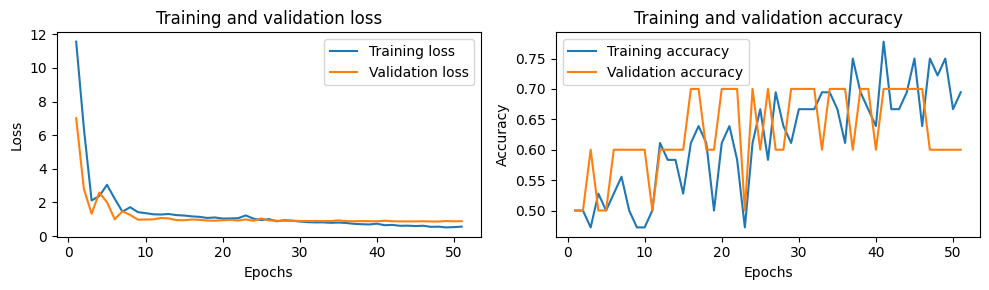

In [ ]:
# Извлечение данных из истории обучения
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plot_history(loss, val_loss, acc, val_acc)

Посмотрим на метрики и ответы модели на тестовой выборке.

In [ ]:
predictions = model.predict(X_test)

accuracy, precision, recall, f1, auc_roc = class_metrics(predictions, y_test_labels)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print(f"AUC-ROC: {auc_roc}")
print(np.argmax(predictions, axis=1))

1/1 [==============================] - 0s 65ms/step
Accuracy: 0.6
Precision: 0.6
Recall: 0.6
F1: 0.6
AUC-ROC: 0.6
[0 1 1 1 0 1 1 0 0 0]


**Попробуем кросс-валидацию и разделим на 4 fold'а**.


In [80]:
# Инициализируем ответы
true_labels = np.zeros(46)
true_labels[::2] = 1

X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train_labels, y_test_labels = train_test_split(X, true_labels, test_size=0.25, random_state=42)

y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

Компилируем модель.

In [157]:
def create_model(input_shape):
    '''
    Initializing sequential model, adding layers
    :param input_shape: input layer shape
    :return: Model
    '''
    init = GlorotNormal(seed=42)
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape, kernel_initializer=init))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax', kernel_initializer=init))
    return model

In [158]:
input_shape = (fixed_length, 1)
model = create_model(input_shape)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_132 (Conv1D)         (None, 18, 128)           512       
                                                                 
 max_pooling1d_132 (MaxPool  (None, 9, 128)            0         
 ing1D)                                                          
                                                                 
 flatten_69 (Flatten)        (None, 1152)              0         
                                                                 
 dense_69 (Dense)            (None, 2)                 2306      
                                                                 
Total params: 2818 (11.01 KB)
Trainable params: 2818 (11.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [159]:
# Рандомно разделяем датасет и ответы на 4 фолда, получаем на выходе массив индексов
folds = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=0).split(X_train, y_train_labels))
# Метод, который сам решает когда остановиться
early_stop = EarlyStopping(monitor='accuracy', min_delta=0.001,
                           patience=10, verbose=1, mode='auto')
loss = []
val_loss = []
acc = []
val_acc = []

# Начинаем обучение
for j, (train_idx, val_idx) in enumerate(folds):
    print('\nFold ', j)

    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv = y_train[val_idx]

    hist = model.fit(X_train_cv, y_train_cv,
                     batch_size=4, epochs=100,
                     callbacks=[early_stop], validation_data=(X_valid_cv, y_valid_cv))

    history_dict = hist.history

    loss += history_dict['loss']
    val_loss += history_dict['val_loss']
    acc += history_dict['accuracy']
    val_acc += history_dict['val_accuracy']

    print(model.evaluate(X_valid_cv, y_valid_cv))


Fold  0
Epoch 1/100
7/7 [==============================] - 1s 29ms/step - loss: 0.6977 - accuracy: 0.4000 - val_loss: 0.6894 - val_accuracy: 0.5556
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5200 - val_loss: 0.6802 - val_accuracy: 0.5556
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 0.6766 - accuracy: 0.5200 - val_loss: 0.6743 - val_accuracy: 0.5556
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6708 - accuracy: 0.5200 - val_loss: 0.6644 - val_accuracy: 0.5556
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6647 - accuracy: 0.5200 - val_loss: 0.6559 - val_accuracy: 0.5556
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6635 - accuracy: 0.5200 - val_loss: 0.6499 - val_accuracy: 0.5556
Epoch 7/100
7/7 [==============================] - 0s 10ms/step - loss: 0.6617 - accuracy: 0.5200 - val_loss: 0.6470 - val_accuracy: 0.5556
Epoch 8/100
7/7 

Получаем предсказание и считаем метрики качества классификации.

In [160]:
predictions = model.predict(X_test)

accuracy, precision, recall, f1, auc_roc = class_metrics(predictions, y_test_labels)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print(f"AUC-ROC: {auc_roc}")
print(np.argmax(predictions, axis=1))

1/1 [==============================] - 0s 51ms/step
Accuracy: 0.5833333333333334
Precision: 0.6
Recall: 0.8571428571428571
F1: 0.7058823529411764
AUC-ROC: 0.5142857142857142
[1 1 1 1 0 1 0 1 1 1 1 1]


Посмотрим на графики обучения.

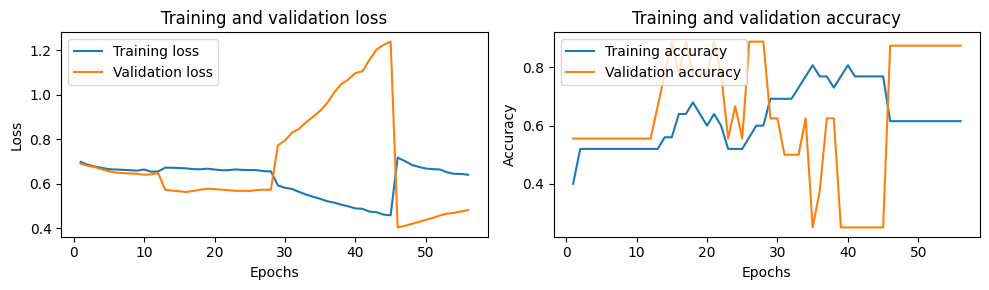

In [161]:
plot_history(loss, val_loss, acc, val_acc)

Теперь обучим модели для каждой нужной нам пары параметров (threshold, n_homologies).

In [163]:
parameters = [0.5, 0.55, 0.6, 0.65, 0.7]
number_of_homologies = [2, 3]
# Инициализируем табличку
df = pd.DataFrame(
    {'n_homologies': [], 'threshold': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc-roc': []})
# Инициализируем ответы
true_labels = np.zeros(46)
true_labels[::2] = 1

y = to_categorical(true_labels)
# Ранняя остановка
early_stop = EarlyStopping(monitor='accuracy', min_delta=0.001,
                           patience=10, verbose=1, mode='auto')

for n_hom in number_of_homologies:
    for param in parameters:
        print(' ')
        print('-' * 50)
        print(' ')
        print(f'Iteration with n = {n_hom}, t = {param} is starting...')
        # Получаем диаграммы устойчивости
        diagrams = load_diagrams(param, n_hom)
        # Преобразуем в векторы
        x = [flatten_diagram(diagram[0]) for diagram in diagrams]
        # shape(x) = (46, 2k)
        fixed_length = min([len(vector) for vector in x])
        print(f'Min shape = {fixed_length}')

        X = np.array([fix_length(vector, fixed_length) for vector in x])
        X = X.reshape(X.shape[0], X.shape[1], 1)

        X_train, X_test, y_train_labels, y_test_labels = train_test_split(X, true_labels, test_size=0.25, random_state=42)

        y_train = to_categorical(y_train_labels)
        y_test = to_categorical(y_test_labels)

        # Инициализирум модель
        input_shape = (fixed_length, 1)
        model = create_model(input_shape)
        # Компилируем модель
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        # Разделяем данные на 4 фолда
        folds = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=0).split(X_train, y_train_labels))
        # Запоминаем ошибки
        loss = []
        val_loss = []
        acc = []
        val_acc = []
        # Обучаемся
        for j, (train_idx, val_idx) in enumerate(folds):
            print('\nFold ', j)

            X_train_cv = X_train[train_idx]
            y_train_cv = y_train[train_idx]
            X_valid_cv = X_train[val_idx]
            y_valid_cv = y_train[val_idx]

            hist = model.fit(X_train_cv, y_train_cv,
                             batch_size=4, epochs=100,
                             callbacks=[early_stop], validation_data=(X_valid_cv, y_valid_cv))

            history_dict = hist.history

            loss += history_dict['loss']
            val_loss += history_dict['val_loss']
            acc += history_dict['accuracy']
            val_acc += history_dict['val_accuracy']

        # Сохраняем модель
        model.save(path + f'/results/cnn/{n_hom}:{param}, model.keras')
        # Предсказываем ответы
        predictions = model.predict(X_test)

        # Вычисление метрик
        accuracy, precision, recall, f1, auc_roc = class_metrics(predictions, y_test_labels)

        new_row = pd.DataFrame([[n_hom, param, accuracy, precision, recall, f1, auc_roc]],
                               columns=['n_homologies', 'threshold', 'accuracy', 'precision', 'recall', 'f1',
                                        'auc-roc'])

        print(new_row)
        # Сохраняем результаты
        df = pd.concat([df, new_row])
        df.to_csv(path + '/results/cnn/result_table_test2.csv', index=False)
        print(f'homology {n_hom} with parameter {param} done')

 
--------------------------------------------------
 
Iteration with n = 2, t = 0.5 is starting...
Min shape = 100

Fold  0
Epoch 1/100
7/7 [==============================] - 1s 47ms/step - loss: 0.7192 - accuracy: 0.5200 - val_loss: 0.6785 - val_accuracy: 0.5556
Epoch 2/100
7/7 [==============================] - 0s 18ms/step - loss: 0.6908 - accuracy: 0.5200 - val_loss: 0.6744 - val_accuracy: 0.5556
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 0.6873 - accuracy: 0.5200 - val_loss: 0.6834 - val_accuracy: 0.5556
Epoch 4/100
7/7 [==============================] - 0s 17ms/step - loss: 0.6816 - accuracy: 0.5200 - val_loss: 0.6662 - val_accuracy: 0.5556
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6711 - accuracy: 0.5200 - val_loss: 0.6568 - val_accuracy: 0.5556
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6758 - accuracy: 0.5200 - val_loss: 0.6542 - val_accuracy: 0.5556
Epoch 7/100
7/7 [==================

In [164]:
df

,n_homologies,threshold,accuracy,precision,recall,f1,auc-roc
0,2.0,0.50,0.333333,0.428571,0.428571,0.428571,0.285714
0,2.0,0.55,0.416667,0.500000,0.142857,0.222222,0.400000
0,2.0,0.60,0.333333,0.333333,0.142857,0.200000,0.314286
0,2.0,0.65,0.416667,0.500000,0.285714,0.363636,0.457143
0,2.0,0.70,0.583333,0.600000,0.857143,0.705882,0.542857
0,3.0,0.50,0.500000,0.571429,0.571429,0.571429,0.485714
0,3.0,0.55,0.416667,0.500000,0.142857,0.222222,0.371429
0,3.0,0.60,0.333333,0.333333,0.142857,0.200000,0.228571
0,3.0,0.65,0.416667,0.500000,0.285714,0.363636,0.457143
0,3.0,0.70,0.583333,0.600000,0.857143,0.705882,0.514286
